In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import entropy2
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)

In [3]:
def ground_truth(x,y):
    return (1.3*x-.5)*(1.3*x-.5) + (y-.5)*(y-.5) < .05

In [4]:
def createSamples(N, xl, xr, yu, yo, ground_truth):
    """
        ground_truth is a function that calculates the "true" label, given coordinates x and y
        Produce N samples in the rectangle [xl, xr, yu, yo] with the given ground_truth
    """
    np.random.seed(1234)
    x = np.random.uniform(xl,xr,N)
    y = np.random.uniform(yu,yo,N)
    c = ground_truth(x, y) * 1.0
    return x, y, c

In [5]:
N = 2000

In [6]:
sx, sy, labels = createSamples(N, 0, 1, 0, 1, ground_truth)
points=np.array([sx, sy])

### The statistical experiment
Please interpret the experiment in the following way: There is some mysterious source of points. Let's call it RED. And there's another source, also producing points - and we call it BLUE. RED distributes its points in a region, defined by some ground truth. BLUE avoids exactly that region. Now, given some points with known origin, we attempt to train a neural network to tell the source from the position of a particular point.   

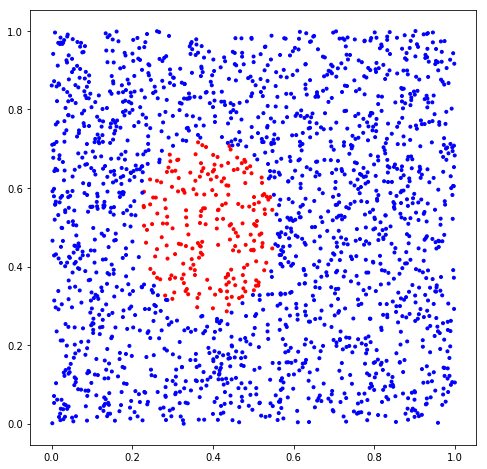

In [7]:
plt.scatter(sx, sy, c=labels, cmap="bwr", marker='.')

### Using Tensorflow tf.data.Datasets

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
training_data = (tf.transpose(points), tf.transpose(labels))
ds_training = tf.data.Dataset.from_tensor_slices(training_data)
it_tr = ds_training.batch(N).repeat().make_one_shot_iterator().get_next()

samples_it= it_tr[0]
labels_it = it_tr[1]

In [10]:
# Hyperparameters governing the differentiable entropy computation
n_bins=5
alpha = 1e3

We're going to use a sigmoid network, thus all ranges span from 0 to 1:

In [11]:
min_max2 = [np.array([0, 0]), np.array([1,1])]
min_max3 = [np.array([0, 0, 0]), np.array([1, 1, 1])]

### Entropy and mutual information in the input signal (the point coordinates)
Compare: With no knowledge of the color, we see a uniform distribution with 5x5=25 buckets - this is what we expect the computed entropy to be close to:

In [12]:
init = tf.global_variables_initializer()

In [13]:
theoretical_limit = -math.log(1/n_bins/n_bins)
actual_entropy, bin_counts = sess.run(entropy2.entropy(samples_it, n_bins, alpha, *min_max2))
_, info_gain = sess.run([init, entropy2.info_gain(samples_it, labels, 2, n_bins, alpha, *min_max2)])
print("theoretical limit: %s - actual entropy: %s" %(theoretical_limit, actual_entropy))
print("information gain: %s" % info_gain)

theoretical limit: 3.2188758248682006 - actual entropy: 3.2127104744772375
information gain: 0.21209776767006439


### Defining the network
We define a little network with two hidden layers of 3 neurons each

In [14]:
W1 = np.array([[1.6, .4], [.6, -1.2], [-.6, 1.6]])     # 3x2 weight Matrix towards the first hidden layer
b1 = np.array([[-1, 1, .3]]).T                           # bias of the first hidden layer
W2 = np.array([[1, .2, -.3], [.5, .2, -.3], [.2, 1, -.2]])  # 3x3 weight Matrix towards the second hidden layer
b2 = np.array([[.2, .1, -.4]]).T                        # bias of the 2nd hidden layer
W3 = np.array([[.2, .1, -.01], [.2, 1, .2]])            # 2x3 weight Matrix towards the output layer
b3 = np.array([[-.2, .1]]).T                             # bias of the output layer

W1_i=tf.constant_initializer(W1.T)
b1_i=tf.constant_initializer(b1)
W2_i=tf.constant_initializer(W2.T)
b2_i=tf.constant_initializer(b2)
W3_i=tf.constant_initializer(W3.T)
b3_i=tf.constant_initializer(b3)

_dense1=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W1_i, bias_initializer=b1_i)
_dense2=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W2_i, bias_initializer=b2_i)
_logits=tf.layers.Dense(2, kernel_initializer=W3_i, bias_initializer=b3_i)    

def get_layers(x):
    hidden1 = _dense1(x)
    hidden2 = _dense2(hidden1)
    y = _logits(hidden2)
    return hidden1, hidden2, y

In [15]:
h1, h2, logits = get_layers(samples_it)
init = tf.global_variables_initializer()
sess.run(init)

In [52]:
_h1, _h2, _lg, sc = sess.run([h1, h2, logits, labels_it])
ph1 = [_h1[:,i] for i in range(3)]
ph2 = [_h2[:,i] for i in range(3)]
plg = [_lg[:,i] for i in range(2)]

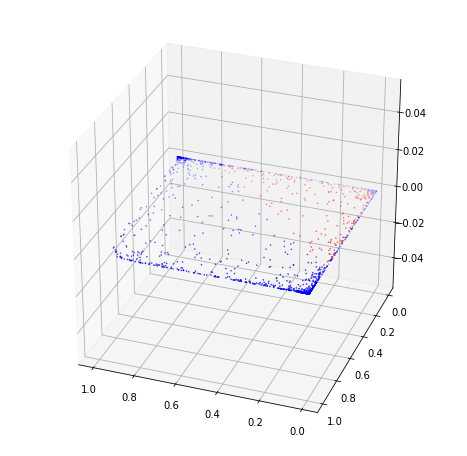

In [53]:
matplotlib.rcParams['figure.figsize'] = (8,8)
plt.axes(projection='3d', elev=30, azim=110)
plt.scatter(*ph1, c=sc, cmap="bwr", marker='.')

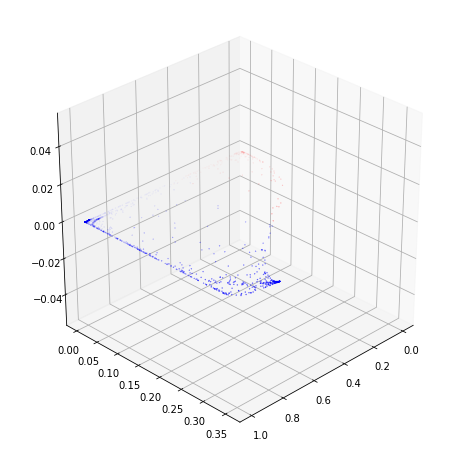

In [54]:
plt.axes(projection='3d', elev=30, azim=45)
plt.scatter(*ph2, c=sc, cmap="bwr", marker='.')

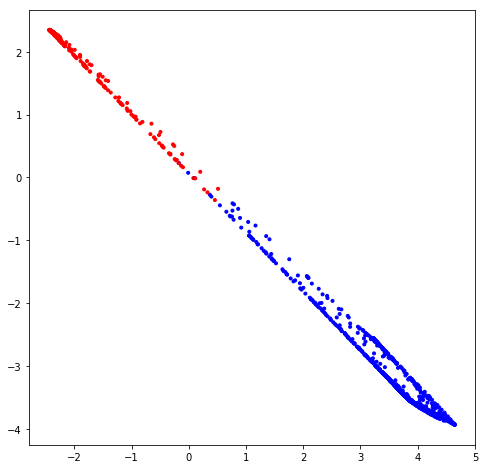

In [55]:
plt.scatter(*plg, c=sc, cmap="bwr", marker='.')

In [20]:
oh_labels=tf.one_hot(labels, depth=2)
objective_ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=oh_labels))
optimizer2 = tf.train.AdamOptimizer(learning_rate=1e-1)
train_ce = optimizer2.minimize(objective_ce)

In [21]:
objective1 = -entropy2.info_gain(h1, labels, 2, n_bins, alpha, *min_max3)
objective2 = -entropy2.info_gain(h2, labels, 2, n_bins, alpha, *min_max3)
preds = tf.argmax(logits,axis=1)

In [22]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, labels), dtype=tf.float64))

In [23]:
init = tf.global_variables_initializer()
sess.run(init)
info_gain1 = []
info_gain2 = []
cross_ent = []
acc_cum  = []

In [50]:
for _ in range(100):
    _, _ce, _ig1, _ig2, _ac = sess.run([train_ce, objective_ce, objective1, objective2, accuracy])
    cross_ent.append(_ce)
    info_gain1.append(_ig1)
    info_gain2.append(_ig2)
    acc_cum.append(_ac)

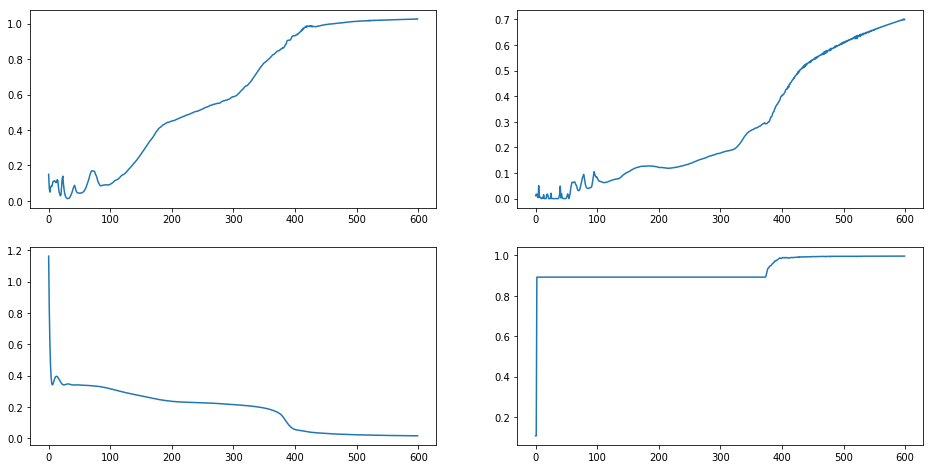

In [51]:
matplotlib.rcParams['figure.figsize'] = (16,8)
plt.subplot(2,2,1)
plt.plot(-np.array(info_gain1))
plt.subplot(2,2,2)
plt.plot(-np.array(info_gain2))
plt.subplot(2,2,3)
plt.plot(np.array(cross_ent))
plt.subplot(2,2,4)
plt.plot(np.array(acc_cum))

In [29]:
w, b = sess.run(dense1.weights)
w, b

(array([[ 2.06575521, -0.42309454,  1.43601633],
        [-0.9065653 , -0.60009498,  1.6210716 ]]),
 array([-0.33861266,  0.20327789,  0.4575974 ]))

In [47]:
ent, _ = sess.run(entropy2.entropy(hidden, n_bins, alpha, *min_max3))
ent

2.1163705331072977

In [46]:
cond, _ = sess.run(entropy2.cond_entropy(hidden, labels, 2, n_bins, alpha, *min_max3))

In [16]:
_hidden = sess.run(hidden)

In [70]:
objective1 = -entropy2.info_gain(h1, labels, 2, n_bins, alpha, *min_max3)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train = optimizer.minimize(objective1)

In [17]:
x = _hidden[:,0]
y = _hidden[:,1]
z = _hidden[:,2]

In [18]:
_lbls = sess.run(labels)
_lbls.shape

(2000,)

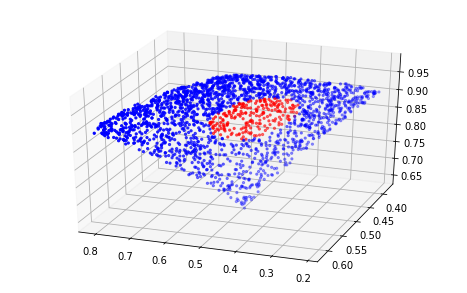

In [29]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=30, azim=110)

ax.scatter(x, y, z, c=sc, cmap="bwr", marker='.')

#### The network

In [41]:
# pass the data through the network
h1, h2, y = feed_forward(samples)

### Running The Network Graph
All steps above have just created the graph, and not actually computed anything

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
_all = sess.run(all_mapped)
_data = _all[:N]
_grid = _all[N:]

In [ ]:
plt.scatter(_grid.T[0], _grid.T[1], marker='.', s=.1, c='k')
plt.scatter(_data.T[0], _data.T[1], marker='o', c=sc, cmap='bwr')

No surprise. Reproducing the former result was what we set out to achieve. This time, it was Tensorflow compute the mapping - thus we can use its powerful API for the training.
### Set up the Training

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
all_input = tf.concat([tensor_training[0], grid_data], axis = 0)

In [ ]:
true_classes = tf.cast(tensor_training[1], dtype=tf.int64)
input = tensor_training[0]

In [ ]:
all_output = feed_forward(all_input)
all_probs = tf.nn.softmax(all_output)
logits = all_output[:N]
probs = tf.nn.softmax(logits)
labels=tf.one_hot(true_classes, depth=2)
objective = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train = optimizer.minimize(objective)

In [ ]:
preds = tf.argmax(probs[:N],axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, true_classes), dtype=tf.float64))

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)

### Training is Hard
You'll need to run the following cell 40 times. You'll see it getting stuck and fighting its way to success after about 35 steps. Then it finally improves step by step until it actually fits the entire training set

In [ ]:
losses = []
accies = []
n_batch = 50

In [ ]:
def draw_manifold(output):
    _data = output[:N]
    _grid = output[N:]
    plt.scatter(_grid.T[0], _grid.T[1], marker='.', s=.1, c='k')
    plt.scatter(_data.T[0], _data.T[1], marker='.', c=sc, cmap='bwr')

In [ ]:
def single_batch(n_batch):
    for _ in range(n_batch):
        _, _all_output, _objective, _accuracy = sess.run([train, all_output, objective, accuracy])

    print ("Loss: %s - Accuracy: %s" % (_objective, _accuracy))
    losses.append(_objective)
    accies.append(_accuracy)
    return _all_output


In [ ]:
# Do a couple of training steps, don't loose your patience. It takes quite some time for the training to kick in
for _ in range (50): # Go by 10 single steps, then 25, then single steps again 
    _all_output = single_batch(n_batch)

    #for _ in range(n_batch):
    #    _, _all_output, _objective, _accuracy = sess.run([train, all_output, objective, accuracy])
    #print ("Loss: %s - Accuracy: %s" % (_objective, _accuracy))
    #losses.append(_objective)
    #accies.append(_accuracy)

# plot the resulting topology
#draw_manifold(_all_output)
_data = _all_output[:N]
_grid = _all_output[N:]
plt.scatter(_grid.T[0], _grid.T[1], marker='.', s=.1, c='k')
plt.scatter(_data.T[0], _data.T[1], marker='.', c=sc, cmap='bwr')

In [ ]:
plt.plot(losses)
plt.plot(accies)